# JRSRP Microservices


_...or how we deliver some of our data online._
<img src = https://media1.giphy.com/media/h55EUEsTG9224/giphy.gif>
To run these examples, I used:
```
Python=-3.7.6
Flask==1.1.1
folium==0.11.0
matplotlib==3.2.1
numpy==1.18.1
requests==2.23.0

```

This all started back in 2013 as a bit of an experiment with [Flask](https://flask.palletsprojects.com/en/1.1.x/)






### What is Flask?
Flask is a lightweight Web Server Gateway Interface (WSGI, pronounced whiskey)  web application framework. It is designed to make getting started quick and easy, with the ability to scale up to complex applications. It has become one of the most popular Python web application frameworks.

<img src=https://flask.palletsprojects.com/en/1.1.x/_images/flask-logo.png>



In [ ]:
# Simple Flask App
from flask import Flask
app = Flask(__name__)

@app.route('/')
def hello_world():
    return 'Hello, World!'

app.run(host="0.0.0.0",port=int("5001"),debug=False)

[http://localhost:5001/](http://localhost:5001/)

First we imported the Flask class. An instance of this class will be our WSGI application.

Next we create an instance of this class. _The first argument is the name of the application’s module or package. If you are using a single module (as in this example), you should use __name__ because depending on if it’s started as application or imported as module the name will be different ('__main__' versus the actual import name). This is needed so that Flask knows where to look for templates, static files, and so on. For more information have a look at the Flask documentation._

We then use the route() decorator to tell Flask what URL should trigger our function.

The function is given a name which is also used to generate URLs for that particular function, and returns the message we want to display in the user’s browser.

We can easily add some methods to get request data. This is a common way to send parameters in a request.


[http://localhost:5002/addstuff?a=3&b=8](http://localhost:5002/addstuff?a=3&b=8)

In [ ]:
# Simple Flask GET App
from flask import Flask, request
app = Flask(__name__)

@app.route('/addstuff',methods = ['GET'])
def getsum():
    a = request.args.get('a') # a is a string
    b = request.args.get('b') # b is a string
    a_plus_b = float(a)+float(b)
    return '{} + {} = {}'.format('a', 'b',a_plus_b)

app.run(host="0.0.0.0",port=int("5002"),debug=False)



## Vegmachine API

In 2016 the VegMachine.net
website was launched to build a wider user base and assure service continuity. Users can now graph historical (1990–) cover
on one or more user defined areas of interest (AOI), produce comprehensive paddock-by-paddock property monitoring
reports, and view a range of land cover raster images through the website map panel. In its first 32 months of operation 913
users logged 1604 sessions on the website and more than 1000 of the website’s most comprehensive monitoring reports
were distributed to users. Levels of use varied; 26% of users have used the website more than once, and within this
group a smaller set of regular users have used the site more than five times, in many cases to provide analyses to
multiple clients. 

<img src=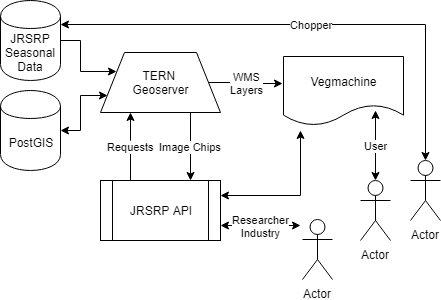>

### A Vegmachine API call uses a geojson polygon


In [ ]:
import folium
queryJson = '{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[133.43032836914062,-24.185594686815637],[133.69537353515625,-24.344594295127965],[133.8629150390625,-24.3470966338085],[134.01947021484375,-24.307053283225915],[134.1485595703125,-24.268249229493193],[134.21173095703125,-24.180583596981705],[134.14581298828125,-24.10539365115648],[133.98788452148438,-24.095364985079073],[133.95767211914062,-24.005071690546163],[133.65692138671875,-23.99252593578858],[133.63494873046875,-24.042701613391596],[133.4674072265625,-24.062766399524932],[133.50173950195312,-24.13923459969371],[133.43032836914062,-24.185594686815637]]]}}]}'
#queryJson = '{"type":"FeatureCollection","features":[{"type":"Feature","properties":{},"geometry":{"type":"Polygon","coordinates":[[[115.6640625,-22.63429269379352],[115.53222656249999,-27.215556209029675],[117.46582031249999,-32.80574473290687],[120.10253906249999,-32.76880048488168],[126.69433593749999,-30.713503990354965],[133.2421875,-30.789036751261136],[139.4384765625,-31.353636941500987],[141.328125,-36.244273184939075],[147.9638671875,-36.84446074079562],[152.1826171875,-26.980828590472107],[142.998046875,-15.538375926292048],[140.8447265625,-19.559790136497398],[134.6923828125,-16.04581345375217],[134.296875,-13.923403897723334],[131.66015625,-13.539200668930816],[129.990234375,-16.003575733881313],[126.298828125,-16.299051014581817],[121.46484375,-20.67390526467283],[115.6640625,-22.63429269379352]]]}}]}'
# Create a basic map showing the location of the query
m = folium.Map(location=[-24, 133.5],
              zoom_start=5,
              tiles='OpenStreetMap')

folium.GeoJson(queryJson).add_to(m)

m

### Call the API using requests

You need to give a [TERN](https://geoserver.tern.org.au/geoserver/web/wicket/bookmarkable/org.geoserver.web.demo.MapPreviewPage) Seasonal Landsat, Sentinel 2 or MOSIS tie series enabled layer.

Optional paramaters include startdate and enddate and rainfall - either monthly or accumulated.

This API accepts GET or POST requests.




In [ ]:
import json
import requests

# Setup the request. 
url = 'https://api.jrsrp.com/tsjson'
params = dict(
    wmsLayer='aus:ground_cover',
    geoJsonPoly=queryJson,
    monthlyRainfall='1')

# GET (or POST) the request
resp = requests.get(url=url, params=params)

# Check that it worked
if resp.status_code == 200:
    # Parse the JSON
    data = json.loads(resp.text)
    # Show the keys in the response
    print('Response Keys: \n',data.keys())
    # Print all the data
    print('\nResponse JSON:\n',json.dumps(data, indent=4, sort_keys=True))
else:
    # Not a 200 Status
    print('Vegmachine API is broken')

### Extracting and plotting mean values through time

In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt

# Extract the datetime stamps from the javascript milliseconds
seasonalTimeStamps = [datetime.datetime.fromtimestamp(val[0]/1000) for val in data['bare']]
rainfallTimeStamps = [datetime.datetime.fromtimestamp(val[0]/1000) for val in data['monthlyRainfall']]

# Extract the mean fractions  for each time period
bareMean = np.array(data['bare'])[:,1]
greenMean = np.array(data['green'])[:,1]
nongreenMean = np.array(data['nongreen'])[:,1]

# Extract the Monthly Rainfall
monthlyRainfall = np.array(data['monthlyRainfall'])[:,1]


# Demonstrate in a plot
fig, ax1 = plt.subplots(figsize=(16,10))
ax2 = ax1.twinx()

ax1.plot(seasonalTimeStamps,bareMean,'r-',label='Bare',linewidth=2)
ax1.plot(seasonalTimeStamps,greenMean,'g-',label='Green',linewidth=2)
ax1.plot(seasonalTimeStamps,nongreenMean,'b-',label='Nongreen',linewidth=2)
ax2.bar(rainfallTimeStamps,monthlyRainfall,label='Rainfall', width=10,color='dimgray')

ax1.set_xlabel('Season Start Date', fontsize=16)
ax1.set_ylabel('Percent Cover', fontsize=16)
ax2.set_ylabel('Monthly Rainfall', fontsize=16)

ax1.legend(loc='best')
ax1.grid(True,linestyle=':')

### What about cover histograms

In [ ]:
bareHist = np.array([hist[1] for hist in data['bareHist']], dtype=np.float)
meanBareHist = np.nanmean(bareHist,axis=0)

# Normalise to 100%
meanBareHist = 100 * meanBareHist / np.nansum(meanBareHist)

fig, ax1 = plt.subplots(figsize=(16,6))

# Plot the Bars - Note the [::-1] that reverses the plot from bare to cover
ax1.bar(np.arange(0,101,1),meanBareHist[::-1], width=0.5)
ax1.set_xlabel('Temporal Mean of Ground Cover %', fontsize=16)
ax1.set_ylabel('Proportion of Polygon (%)', fontsize=16)
ax1.grid()




## The Calculator  (Or PEPER) API

PEPER stands for Paddock Erosion Predictor Employing RUSLE (the Revised Universal Soil Loss Equation). PEPER GIS was developed in ArcMap™ 10.0 under the ArcInfo license, and is designed to be run under this or subsequent versions of this program.

The RUSLE: $$ Erosion Rate (t/ha/yr)  = R \cdot K \cdot L \cdot S \cdot C \cdot P $$
Where:
 - R = Rainfall factor
 - K = Soil erosivity factor
 - S = Slope factor
 - L = Slope length factor
 - C = Cover factor
 - P = Erosion control practice factor

Conceptually __The Calculator__ is a web page front end where a polygon can be drawn and the P2R management practice questions will be answered and an ABCD change will be assigned. The website also holds Mark Silburns’s cover factor change look table so will assign a cover change factor. This website will then query the API, run web PEPER, and get back a before and after soil loss. It will then display the savings.

Internally the API calculates the RUSLE using 5 years of late dry season ground cover images and a statewide RKLS layer. The cover factor is calculated fromt the cover images before and after __P__ractice change calculated from a practice change lookup table (like the one below). These practice changes are mapped into the API as a lookup table of best fitting exponential curve from multiple runs of the Agricultural Production Systems sIMulator ([APSIM](https://www.apsim.info/)) for the land type of interest.




| LANDTYPE     | DATATYPE | FORTYPE | MGT_FROM | MGT_TO | NONLINEAR_A | NONLINEAR_B |
|--------------|----------|---------|----------|--------|-------------|-------------|
| Black basalt | C-Factor | Open    | B        | A      | 0.23        | 0.79        |
| Black basalt | C-Factor | Closed  | B        | A      | 0.29        | 0.82        |
| Black basalt | C-Factor | Closed  | C        | A      | 0.15        | 0.82        |
| Black basalt | C-Factor | Open    | C        | A      | 0.15        | 0.9         |
| Black basalt | C-Factor | Closed  | C        | B      | 0.48        | 1.01        |
| Black basalt | C-Factor | Open    | C        | B      | 0.63        | 1.2         |
| Black basalt | C-Factor | Open    | D        | A      | 0.11        | 0.96        |
| Black basalt | C-Factor | Closed  | D        | A      | 0.17        | 1.13        |
| Black basalt | C-Factor | Open    | D        | B      | 0.43        | 1.27        |
| Black basalt | C-Factor | Closed  | D        | B      | 0.54        | 1.35        |
| Black basalt | C-Factor | Open    | D        | C      | 0.93        | 1.26        |
| Black basalt | C-Factor | Closed  | D        | C      | 1.43        | 1.52        |



In [ ]:
import json
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt

'''
 Example request JSON
 This list of json colections was built in iteration with Truii and DAF
 to allow rapid batch processing of entire catchments cut into land types.
 The parameters here are for Closed Black Basalt moving from D to A condition.
'''

targetJson ='[{"NONLINEAR_A":0.17,"NONLINEAR_B":1.13,"geoJsonPoly":{"type":"FeatureCollection","features":[{"type":"Feature","properties":{"Name":"Test1"},"geometry":{"type":"Polygon","coordinates":[[[150.43823719024658,-25.71230623794325],[150.45475959777832,-25.71230623794325],[150.45475959777832,-25.697766921690764],[150.43823719024658,-25.697766921690764],[150.43823719024658,-25.71230623794325]]]}}]}}]'

# Setup the request. This request uses RAW POST data only (so data= not params= in the request)
url = 'https://api.jrsrp.com/grazproj'
resp = requests.post(url=url, data=targetJson)

# Check that it worked
if resp.status_code == 200:
    # Parse the JSON
    data = json.loads(resp.text)
    # Print all the data
    print(json.dumps(data, indent=4, sort_keys=True))
else:
    # Not a 200 Status
    print('Vegmachine API is broken')


In [ ]:
featureData=data[0]['features'][0]['properties']
# Extract the feature data from the list of JSON
currentErosionRate1519 = [featureData[key] for key in featureData if 'currentErosionRate20' in key ]
targetErosionRate1519 = [featureData[key] for key in featureData if 'targetErosionRate20' in key ]
meanCover1519 = [featureData[key] for key in featureData if 'meanCover20' in key ]

# Smooth the Cover to make the plot pretty, reducing it's scientific value...
from scipy.interpolate import make_interp_spline
xnew = np.linspace(2015, 2019, 100)  
meanCover1519 = make_interp_spline(range(2015,2020),meanCover1519, k=2)(xnew)

# Demonstrate in a plot
fig, ax1 = plt.subplots(figsize=(16,10))
ax2 = ax1.twinx()

ax1.plot(range(2015,2020),currentErosionRate1519,'mo:',label='Current Erosion Rate',linewidth=2)
ax1.plot(range(2015,2020),targetErosionRate1519,'co:',label='Target Erosion Rate',linewidth=2)
ax2.plot(xnew,meanCover1519,'g-.',label='Mean Ground Cover',linewidth=3)

ax1.set_xlabel('Year (Autumn Season)', fontsize=16)
ax1.set_ylabel('Erosion (T/Ha/Year)', fontsize=16)
ax2.set_ylabel('Ground Cover (%)', fontsize=16)
ax1.xaxis.set_major_locator(plt.MaxNLocator(5))
ax1.legend(loc='best')
ax2.legend(loc='best')
ax1.grid(True)



## These need better API documentation

Ideally these API's should self document. The [OpenAPI](https://www.openapis.org/) Specification is a broadly adopted industry standard for describing modern APIs. Sme of the more popular tools implementing this are by [Swagger](https://swagger.io/) and [GraphQL](https://graphql.org/) which is seeing increasing use. The example below is from farm management company [Agriwebb](https://www.agriwebb.com/au/).

In [ ]:
%%html
<iframe src="https://api.agriwebb.com/v2" width="990" height="600"></iframe>


## Microservice Processing on  AWS
AWS Lambda is a serverless compute service that runs your code in response to events and automatically manages the underlying compute resources for you. Essentially on-demand cloud computing, Lambda functions have proven capable of transparent and automatic scaling, terrific flexibility, and ease of maintenance, all while being cheaper than always-running alternatives. 

Lambda runs your code on high-availability compute infrastructure and performs all the administration of the compute resources, including server and operating system maintenance, capacity provisioning and automatic scaling, code and security patch deployment, and code monitoring and logging. All you need to do is supply the code.


<img src=https://chalice.readthedocs.io/en/latest/_images/chalice-logo-whitespace.png>

[Chalice](https://github.com/aws/chalice) is a framework for writing serverless apps in python. It allows you to quickly create and deploy applications that use AWS Lambda. It provides:

 - A command line tool for creating, deploying, and managing your app
 - A decorator based API for integrating with Amazon API Gateway, Amazon S3, Amazon SNS, Amazon SQS, and other AWS services.
 - Automatic IAM policy generation
 
You can create:
 - Rest APIs:
 - Tasks that run on a periodic basis
 - You can connect a lambda function to an S3 event
 - As well as an Simple Queue Service messaging queue


<img src=https://miro.medium.com/max/1344/0*rJwNq6zZV2xeeozd.jpg>

The [Geolambda](https://github.com/developmentseed/geolambda) project was started by Radiant Earth with AWS Lambda functions in mind. It provides public Docker images and AWS Lambda Layers containing common geospatial native libraries. GeoLambda contains the libraries PROJ.5, GEOS, GeoTIFF, HDF4/5, SZIP, NetCDF, OpenJPEG, WEBP, ZSTD, and GDAL. But AWS Lambda imposes a **50MB** size limit to zip files you upload. Uncompressed (unzipped) files cannot exceed 250MB. 


### DEALabs Experiment
Can we run geospatial workloads on AWS Lambda using the DEA Sentinel 2 data stored in S3, accessing 30 TFLOPS of compute by the millisecond?

<img src=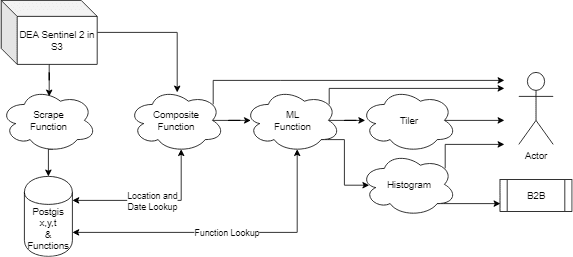>


### Tile Service Demonstration
Builds a 16 day median cloud masked mosaic of DEA COGs on AWS S3 then applies a tensorflow lite model in respone to  WMTS calls.


In [ ]:
import folium

# Create a basic map
m = folium.Map(location=[-30, 152],
              zoom_start=9,
              tiles='OpenStreetMap')

# Link to a WMS service powered by AWS Lambda
lambdaFC = folium.raster_layers.WmsTileLayer(url = 'https://qgis.cibolabs.com/?',
                                             layers='16 Day Median Fractional Cover',
                                             fmt='image/png',
                                             attr='Data from ESA, Processing by DEA, FC Algorithm by JRSRP',
                                             transparent=True,
                                             version='1.3.0')

lambdaFC.add_to(m)
m